## Development for pyadjoint applied to time-dependent mesh adaptation

Suppose we have a time-dependent simulation over $[0, T]$ which is defined on mesh $\mathcal H_1$ for the first half of the time period and mesh $\mathcal H_2$ for the second half.

Suppose for now that the QoI, $J$, is evaluated at $t=T$.

This means that on $[0,T/2]$ we don't have a QoI to evaluate. Instead, we need to propagate the adjoint action from $t=T/2$, i.e. we need a _restart_.

### Algorithm
* Solve forward without annotation to get checkpoints.
* Solve forward on $\mathcal H_2$ over $[T/2,T]$ with annotation.
* Assemble $J$ using the solution at $t=T$.
* Solve adjoint on $\mathcal H_2$ over $[T/2,T]$ using annotated tape. Save adjoint solution at $t=T/2$.
* Solve forward on $\mathcal H_1$ over $[0,T/2]$ with annotation.
* Compute the action of the adjoint solution at $t=T/2$ on $\mathcal H_1$.
* Solve adjoint on $\mathcal H_1$ over $[0,T/2]$ using annotated tape and saved adjoint solution at $t=T/2$.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from firedrake import *
from firedrake_adjoint import *
from firedrake.adjoint.blocks import SolveVarFormBlock

To account for the restarts, we allow passing the adjoint action restart to `solve_adjoint`, instead of the QoI.

In [2]:
def solve_adjoint(*args, tape=None):
    """
    Solver for adjoint problems based on the annotated tape.
    
    There are two options for the first argument:
      1. an annotated assembled objective functional;
      2. the adjoint action of the final time condition for the adjoint problem.
    """
    tape = tape or get_working_tape()
    if isinstance(args[0], AdjFloat):
        J = args[0]
        tape.reset_variables()
        J.adj_value = 1.0
    else:
        last_block = tape._blocks[-1]
        if len(last_block._outputs) != 1:
            raise NotImplementedError
        last_block._outputs[0].adj_value = args[0]

    with stop_annotating():
        tape.evaluate_adj(markings=False)

Define two simple meshes.

In [3]:
n = 32
left_mesh = UnitSquareMesh(n, n, diagonal='left')
right_mesh = UnitSquareMesh(n, n, diagonal='right')

Consider the meshes to be identical, for now.

In [14]:
meshes = [left_mesh, left_mesh]
function_spaces = [VectorFunctionSpace(mesh, "CG", 2) for mesh in meshes]

Take the setup of the [Burgers equation](https://firedrakeproject.org/demos/burgers.py.html) demo and wrap it in a function which depends on the mesh, as well as the `Constant` diffusivity $\nu>0$ and some time integration parameters:

In [5]:
nu = Constant(0.0001)
dt = 1.0/n
end_time = 1/2
# timesteps_per_export = 4
timesteps_per_export = 2
num_timesteps = int(end_time/dt)
num_meshes = len(meshes)
num_exports = num_timesteps//timesteps_per_export
num_exports_per_mesh = num_exports//num_meshes

In [6]:
def solve_burgers_step(ic, annotate=True, step=0):
    v = TestFunction(ic.function_space())
    
    # Current solution and time-lagged solution
    u_ = Function(ic.function_space())
    u = Function(ic.function_space(), name="Velocity")

    # Assign initial condition
    u_ = ic.copy(deepcopy=True)
    u.assign(u_, annotate=annotate)
    
    # Define nonlinear form
    F = (inner((u - u_)/dt, v) + inner(dot(u, nabla_grad(u)), v) + nu*inner(grad(u), grad(v)))*dx
        
    # Time integration loop
    i = 0
    t = step*end_time/num_meshes
    while t < (step+1)*end_time/num_meshes:
        solve(F == 0, u, annotate=annotate)
        u_.assign(u, annotate=annotate)
        t += dt
        i += 1
        
    return u

In [13]:
def run_algorithm(spaces):
    tape = get_working_tape()
    tape.clear_tape()

    # Do some (very simplistic) checkpointing to get the forward restarts
    checkpoints = [None for space in spaces]
    checkpoints[0] = interpolate(as_vector([sin(pi*SpatialCoordinate(meshes[0])[0]), 0]), spaces[0])
    for i in range(len(meshes)-1):
        sol = solve_burgers_step(checkpoints[i], annotate=False, step=i)
        checkpoints[i+1] = project(sol, spaces[i+1], annotate=False)

    # Loop over the meshes *in reverse*, iteratively solving the forward and adjoint
    adjoint_solution = None
    adjoint_action = None
    fig, axs = plt.subplots(num_exports_per_mesh+1, num_meshes, sharex='col', figsize=(10, 10))
    for i in range(num_meshes-1, -1, -1):
        axs[0, i].set_title("Mesh {:d}".format(i+1))

        # Solve forward problem
        sol = solve_burgers_step(checkpoints[i], annotate=True, step=i)

        with stop_annotating():

            # Get "final time condition" and corresponding adjoint action
            if i == num_meshes-1:
                adjoint_action = assemble(derivative(inner(sol, sol)*ds(2), sol))
                ic = adjoint_action
            else:
                ic = project(adjoint_solution, spaces[i])
                adjoint_action = project(adjoint_action, spaces[i])

            # Solve adjoint problem
            solve_adjoint(adjoint_action)

            # Plot adjoint solutions
            fig.colorbar(tricontourf(ic, axes=axs[0, i]), ax=axs[0, i]);
            axs[0, i].annotate('t={:.2f}'.format((i+1)*end_time/num_meshes), (0.05, 0.05), color='white');
            solve_blocks = [block for block in tape.get_blocks() if isinstance(block, SolveVarFormBlock)]
            n = len(solve_blocks)
            for j, jj in zip(range(n-timesteps_per_export, -1, -timesteps_per_export), range(1, num_exports+1)):
                adjoint_solution = solve_blocks[j].adj_sol
                fig.colorbar(tricontourf(adjoint_solution, axes=axs[jj, i]), ax=axs[jj, i]);
                axs[jj, i].annotate('t={:.2f}'.format(i*end_time/num_meshes + j*dt), (0.05, 0.05), color='white');

            # Get adjoint action
            adjoint_action = Function(spaces[i], val=solve_blocks[0]._dependencies[2].adj_value)
            # TODO: Generalise (the index 2 probably won't always work)

        tape.clear_tape()

Everything is set up. Now run the algorithm.

<IPython.core.display.Javascript object>


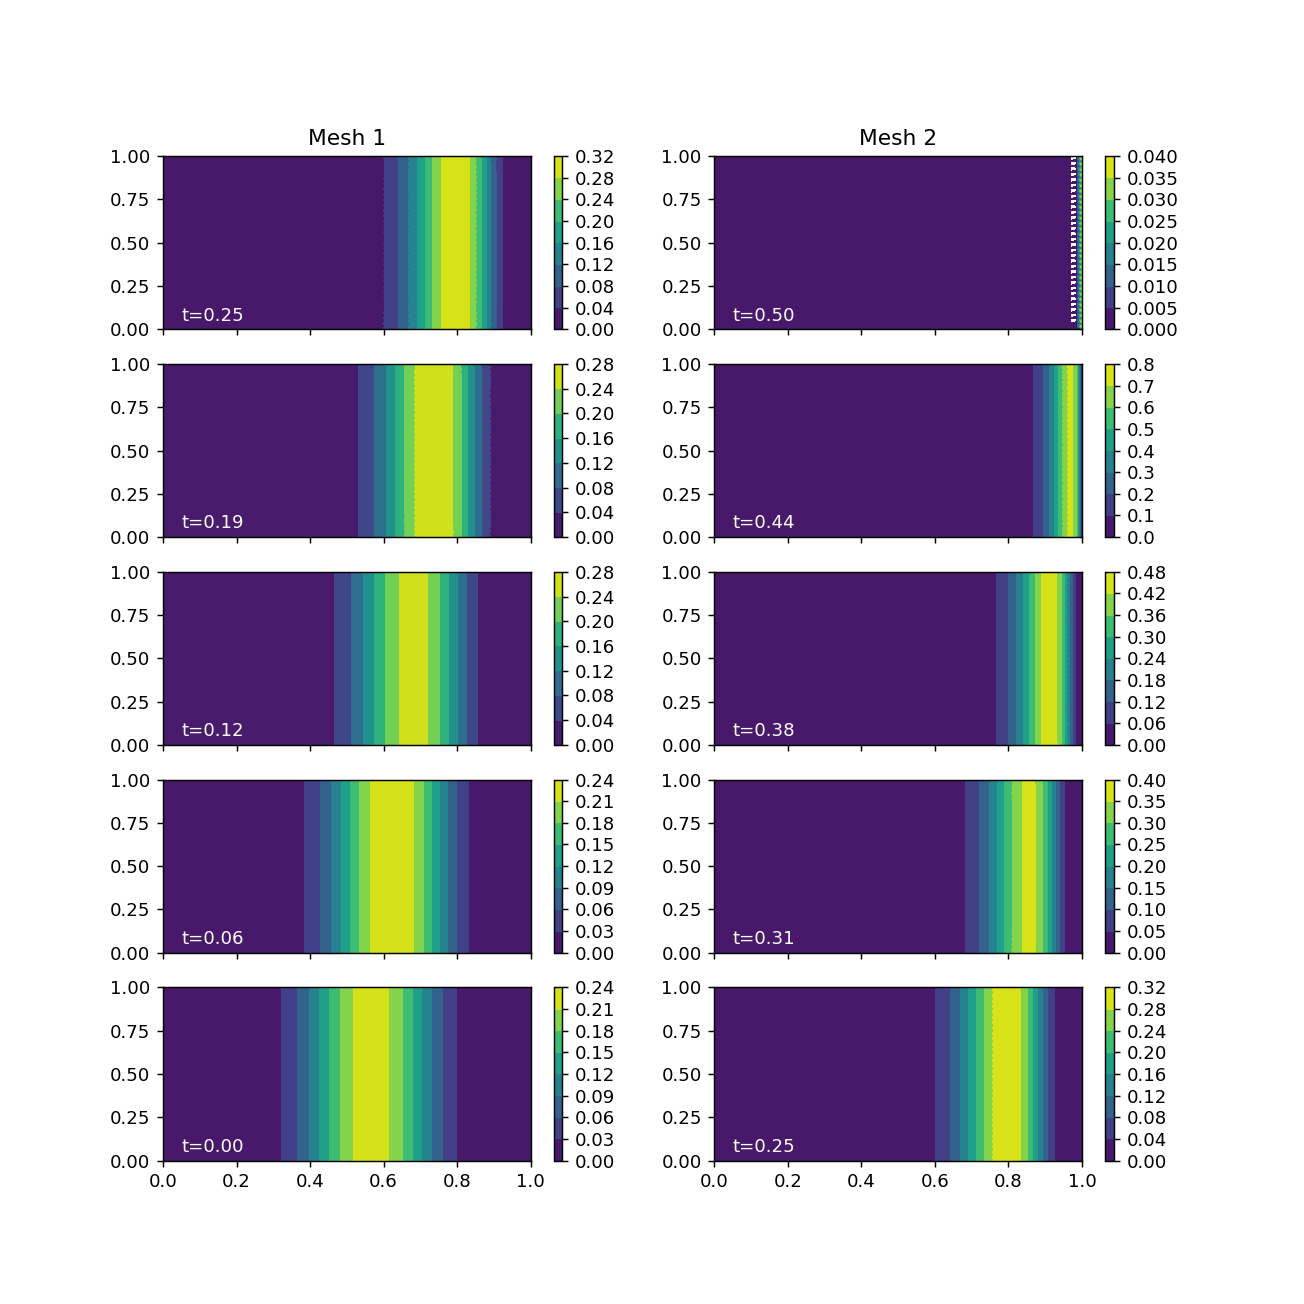

In [15]:
run_algorithm(function_spaces)

The restarts work nicely in the case where the two meshes are identical. (Compare with the plots at the end of [this notebook](https://github.com/firedrakeproject/firedrake/blob/master/docs/notebooks/11-extract-adjoint-solutions.ipynb).)

Now try different meshes.

In [16]:
meshes = [left_mesh, right_mesh]
function_spaces = [VectorFunctionSpace(mesh, "CG", 2) for mesh in meshes]

<IPython.core.display.Javascript object>


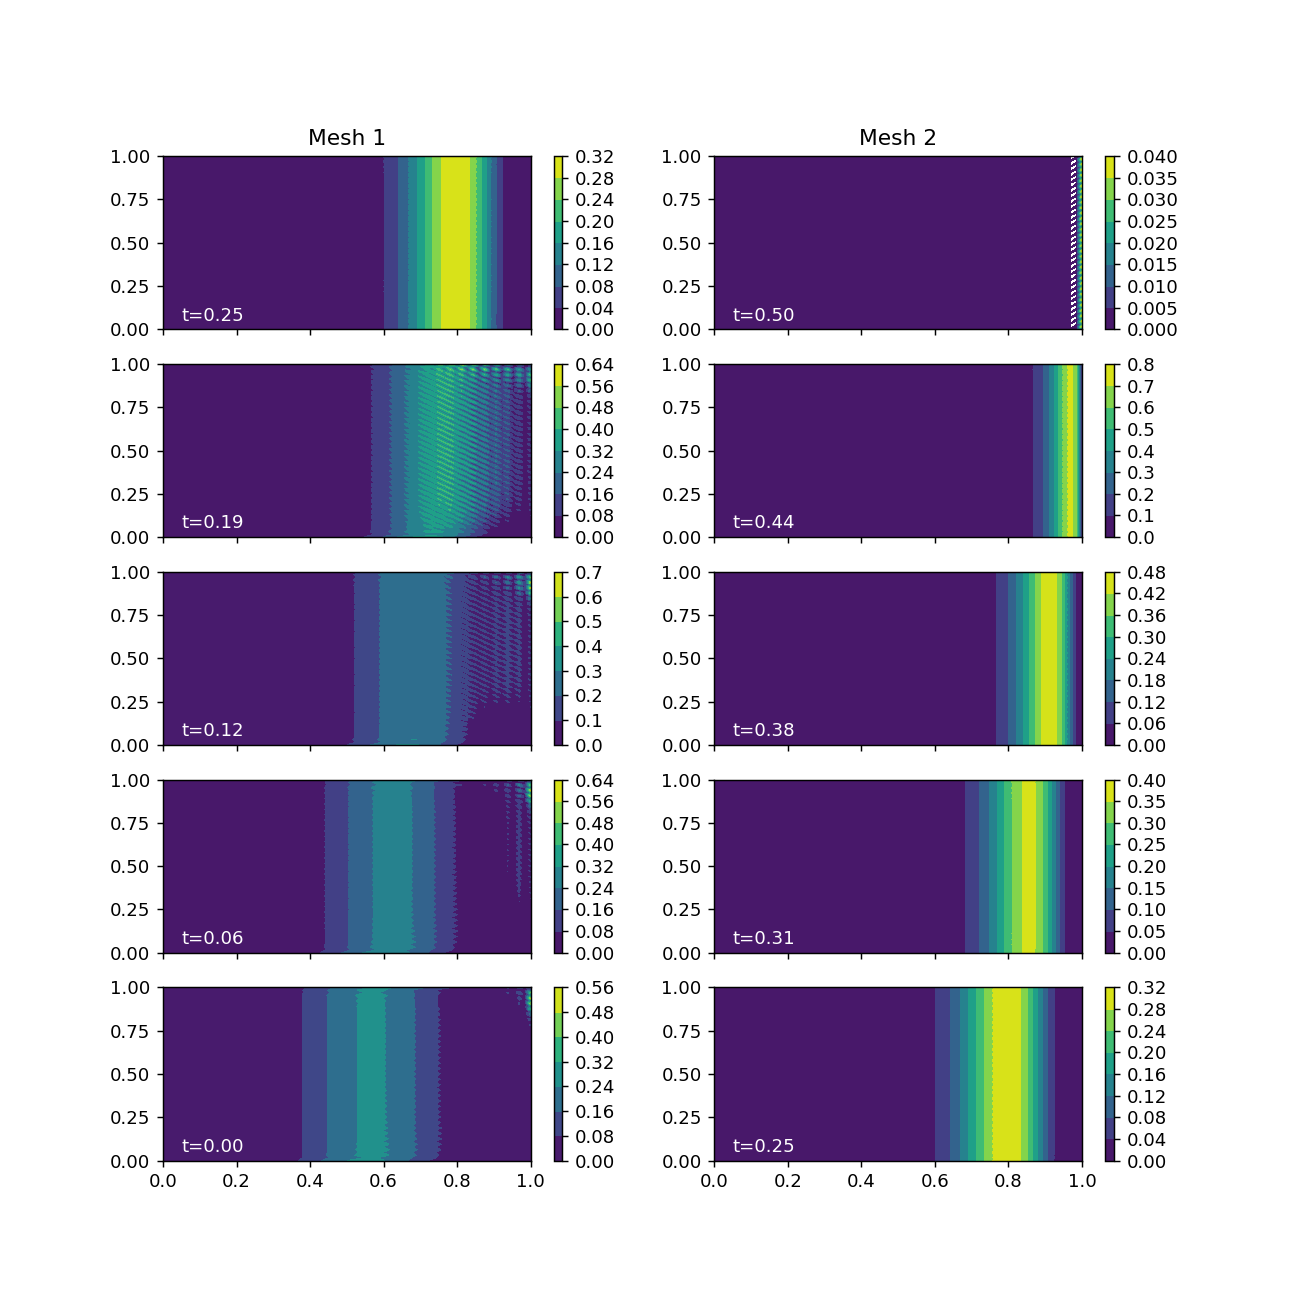

In [17]:
run_algorithm(function_spaces)

It looks like the adjoint action needs to be evaluated on mesh $\mathcal H_1$ (rather than projected from $\mathcal H_2$) in order for the adjoint problem to be set up correctly.